##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 훈련 후 동적 범위 양자화

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/lite/performance/post_training_quant"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/lite/performance/post_training_quant.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/lite/performance/post_training_quant.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/lite/performance/post_training_quant.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
  <td><a href="https://tfhub.dev/google/imagenet/resnet_v2_101/classification/4"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TF 허브 모델 보기</a></td>
</table>

## 개요

[TensorFlow Lite](https://www.tensorflow.org/lite/)은 이제 tensorflow graphdefs에서 TensorFlow Lite의 플랫 버퍼 형식으로의 모델 변환의 일부로써 가중치를 8bit 정밀도로 변환하는 것을 지원합니다. 동적 범위 양자화는 모델 크기를 4배 줄입니다. 또한 TFLite는 활성화의 즉석 양자화 및 역양자화를 지원하여 다음을 허용합니다.

1. 가능한 경우 더 빠른 구현을 위해 양자화된 커널 사용하기
2. 그래프의 다른 부분에 대해 부동 소수점 커널과 양자화된 커널을 혼합하기

활성화는 항상 부동 소수점에 저장됩니다. 양자화된 커널을 지원하는 연산의 경우 활성화는 처리 전에 동적으로 8bit 정밀도로 양자화되고 처리 후 float 정밀도로 역양자화됩니다. 따라서 변환되는 모델에 따라 이 방식으로 순수한 부동 소수점 계산보다 속도를 높일 수 있습니다.

[양자화 인식 훈련](https://github.com/tensorflow/tensorflow/tree/r1.14/tensorflow/contrib/quantize)과 달리 가중치는 훈련 후 양자화되고 활성화는 이 메서드의 추론에서 동적으로 양자화됩니다. 따라서 모델 가중치는 양자화로 인한 오류를 보상하기 위해 재훈련되지 않습니다. 저하가 허용 가능한지 확인하기 위해 양자화된 모델의 정확성을 확인하는 것이 중요합니다.

이 가이드에서는 MNIST 모델을 처음부터 훈련하고 TensorFlow에서 정확성을 확인한 다음 동적 범위 양자화를 사용하여 모델을 Tensorflow Lite flatbuffer로 변환합니다. 마지막으로 변환된 모델의 정확성을 확인하고 원본 float 모델과 비교합니다.

## MNIST 모델 빌드하기

### 설정

In [1]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib

ModuleNotFoundError: No module named 'tensorflow'

### TensorFlow 모델 훈련하기

In [3]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=1,
  validation_data=(test_images, test_labels)
)


   1/1875 [..............................] - ETA: 1:18:00 - loss: 2.2821 - accuracy: 0.0938


  21/1875 [..............................] - ETA: 4s - loss: 2.1042 - accuracy: 0.3869     


  43/1875 [..............................] - ETA: 4s - loss: 1.8275 - accuracy: 0.5494


  65/1875 [>.............................] - ETA: 4s - loss: 1.5329 - accuracy: 0.6298


  88/1875 [>.............................] - ETA: 4s - loss: 1.3056 - accuracy: 0.6797


 110/1875 [>.............................] - ETA: 4s - loss: 1.1492 - accuracy: 0.7165


 132/1875 [=>............................] - ETA: 4s - loss: 1.0298 - accuracy: 0.7443


 155/1875 [=>............................] - ETA: 4s - loss: 0.9399 - accuracy: 0.7625


 178/1875 [=>............................] - ETA: 3s - loss: 0.8732 - accuracy: 0.7776


 201/1875 [==>...........................] - ETA: 3s - loss: 0.8223 - accuracy: 0.7887


 224/1875 [==>...........................] - ETA: 3s - loss: 0.7750 - accuracy: 0.7997


 247/1875 [==>...........................] - ETA: 3s - loss: 0.7379 - accuracy: 0.8088


 269/1875 [===>..........................] - ETA: 3s - loss: 0.7054 - accuracy: 0.8174


 291/1875 [===>..........................] - ETA: 3s - loss: 0.6765 - accuracy: 0.8247


 314/1875 [====>.........................] - ETA: 3s - loss: 0.6455 - accuracy: 0.8318


 337/1875 [====>.........................] - ETA: 3s - loss: 0.6222 - accuracy: 0.8373


 359/1875 [====>.........................] - ETA: 3s - loss: 0.6015 - accuracy: 0.8419


 381/1875 [=====>........................] - ETA: 3s - loss: 0.5818 - accuracy: 0.8462


 403/1875 [=====>........................] - ETA: 3s - loss: 0.5650 - accuracy: 0.8503


 425/1875 [=====>........................] - ETA: 3s - loss: 0.5500 - accuracy: 0.8537


 446/1875 [======>.......................] - ETA: 3s - loss: 0.5341 - accuracy: 0.8580


 467/1875 [======>.......................] - ETA: 3s - loss: 0.5231 - accuracy: 0.8607


 489/1875 [======>.......................] - ETA: 3s - loss: 0.5097 - accuracy: 0.8641


 511/1875 [=======>......................] - ETA: 3s - loss: 0.4972 - accuracy: 0.8669


 533/1875 [=======>......................] - ETA: 3s - loss: 0.4871 - accuracy: 0.8691


 555/1875 [=======>......................] - ETA: 3s - loss: 0.4790 - accuracy: 0.8714


 577/1875 [========>.....................] - ETA: 3s - loss: 0.4700 - accuracy: 0.8732


 599/1875 [========>.....................] - ETA: 2s - loss: 0.4616 - accuracy: 0.8752


 621/1875 [========>.....................] - ETA: 2s - loss: 0.4542 - accuracy: 0.8768


 643/1875 [=========>....................] - ETA: 2s - loss: 0.4464 - accuracy: 0.8788


 665/1875 [=========>....................] - ETA: 2s - loss: 0.4398 - accuracy: 0.8801


 688/1875 [==========>...................] - ETA: 2s - loss: 0.4325 - accuracy: 0.8819


 710/1875 [==========>...................] - ETA: 2s - loss: 0.4251 - accuracy: 0.8840


 732/1875 [==========>...................] - ETA: 2s - loss: 0.4192 - accuracy: 0.8853


 754/1875 [===========>..................] - ETA: 2s - loss: 0.4120 - accuracy: 0.8875


 776/1875 [===========>..................] - ETA: 2s - loss: 0.4084 - accuracy: 0.8882


 798/1875 [===========>..................] - ETA: 2s - loss: 0.4036 - accuracy: 0.8895


 820/1875 [============>.................] - ETA: 2s - loss: 0.3995 - accuracy: 0.8904


 842/1875 [============>.................] - ETA: 2s - loss: 0.3950 - accuracy: 0.8916


 864/1875 [============>.................] - ETA: 2s - loss: 0.3896 - accuracy: 0.8932


 886/1875 [=============>................] - ETA: 2s - loss: 0.3849 - accuracy: 0.8945


 908/1875 [=============>................] - ETA: 2s - loss: 0.3813 - accuracy: 0.8957


 930/1875 [=============>................] - ETA: 2s - loss: 0.3774 - accuracy: 0.8968


 952/1875 [==============>...............] - ETA: 2s - loss: 0.3730 - accuracy: 0.8978


 975/1875 [==============>...............] - ETA: 2s - loss: 0.3686 - accuracy: 0.8990


 996/1875 [==============>...............] - ETA: 2s - loss: 0.3638 - accuracy: 0.9003


1019/1875 [===============>..............] - ETA: 1s - loss: 0.3590 - accuracy: 0.9015


1041/1875 [===============>..............] - ETA: 1s - loss: 0.3558 - accuracy: 0.9021


1063/1875 [================>.............] - ETA: 1s - loss: 0.3518 - accuracy: 0.9033


1085/1875 [================>.............] - ETA: 1s - loss: 0.3480 - accuracy: 0.9042


1107/1875 [================>.............] - ETA: 1s - loss: 0.3451 - accuracy: 0.9050


1129/1875 [=================>............] - ETA: 1s - loss: 0.3424 - accuracy: 0.9056


1150/1875 [=================>............] - ETA: 1s - loss: 0.3393 - accuracy: 0.9065


1172/1875 [=================>............] - ETA: 1s - loss: 0.3363 - accuracy: 0.9073


1194/1875 [==================>...........] - ETA: 1s - loss: 0.3339 - accuracy: 0.9077


1216/1875 [==================>...........] - ETA: 1s - loss: 0.3312 - accuracy: 0.9084


1238/1875 [==================>...........] - ETA: 1s - loss: 0.3279 - accuracy: 0.9094


1260/1875 [===================>..........] - ETA: 1s - loss: 0.3248 - accuracy: 0.9103


1282/1875 [===================>..........] - ETA: 1s - loss: 0.3222 - accuracy: 0.9111


1304/1875 [===================>..........] - ETA: 1s - loss: 0.3200 - accuracy: 0.9118


1326/1875 [====================>.........] - ETA: 1s - loss: 0.3170 - accuracy: 0.9126


1349/1875 [====================>.........] - ETA: 1s - loss: 0.3143 - accuracy: 0.9133


1372/1875 [====================>.........] - ETA: 1s - loss: 0.3116 - accuracy: 0.9139


1394/1875 [=====================>........] - ETA: 1s - loss: 0.3091 - accuracy: 0.9145


1416/1875 [=====================>........] - ETA: 1s - loss: 0.3067 - accuracy: 0.9151


1438/1875 [======================>.......] - ETA: 1s - loss: 0.3035 - accuracy: 0.9160


1460/1875 [======================>.......] - ETA: 0s - loss: 0.3012 - accuracy: 0.9168


1482/1875 [======================>.......] - ETA: 0s - loss: 0.2990 - accuracy: 0.9174


1504/1875 [=======================>......] - ETA: 0s - loss: 0.2967 - accuracy: 0.9180


1526/1875 [=======================>......] - ETA: 0s - loss: 0.2946 - accuracy: 0.9184


1547/1875 [=======================>......] - ETA: 0s - loss: 0.2929 - accuracy: 0.9190


1569/1875 [========================>.....] - ETA: 0s - loss: 0.2908 - accuracy: 0.9196


1591/1875 [========================>.....] - ETA: 0s - loss: 0.2889 - accuracy: 0.9201


1613/1875 [========================>.....] - ETA: 0s - loss: 0.2869 - accuracy: 0.9206


1636/1875 [=========================>....] - ETA: 0s - loss: 0.2847 - accuracy: 0.9212


1658/1875 [=========================>....] - ETA: 0s - loss: 0.2824 - accuracy: 0.9219


1681/1875 [=========================>....] - ETA: 0s - loss: 0.2810 - accuracy: 0.9222


1704/1875 [==========================>...] - ETA: 0s - loss: 0.2789 - accuracy: 0.9228


1726/1875 [==========================>...] - ETA: 0s - loss: 0.2771 - accuracy: 0.9233


1748/1875 [==========================>...] - ETA: 0s - loss: 0.2755 - accuracy: 0.9237


1770/1875 [===========================>..] - ETA: 0s - loss: 0.2733 - accuracy: 0.9244


1792/1875 [===========================>..] - ETA: 0s - loss: 0.2716 - accuracy: 0.9248


1814/1875 [============================>.] - ETA: 0s - loss: 0.2696 - accuracy: 0.9254


1837/1875 [============================>.] - ETA: 0s - loss: 0.2682 - accuracy: 0.9258


1860/1875 [============================>.] - ETA: 0s - loss: 0.2663 - accuracy: 0.9263


1875/1875 [==============================] - 8s 3ms/step - loss: 0.2650 - accuracy: 0.9266 - val_loss: 0.1233 - val_accuracy: 0.9642


예를 들어, 단일 epoch에 대해서만 모델을 훈련했기 때문에 최대 96%의 정확성으로만 훈련됩니다.


### TensorFlow Lite 모델로 변환하기

TensorFlow Lite [Converter](https://www.tensorflow.org/lite/models/convert)를 사용하여 이제 훈련된 모델을 TensorFlow Lite 모델로 변환할 수 있습니다.

`TFLiteConverter`를 사용하여 모델을 로드합니다.

In [4]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpq7400iyt/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpq7400iyt/assets


2022-12-15 01:03:20.786774: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-15 01:03:20.786817: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


tflite 파일에 작성합니다.

In [5]:
tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [6]:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

84820

내보낼 때 모델을 양자화하려면 `optimizations` 플래그를 지정하여 크기를 최적화합니다.

In [7]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp5povdt1q/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp5povdt1q/assets


2022-12-15 01:03:21.721141: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-15 01:03:21.721182: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


24064

결과 파일의 약 `1/4` 크기인지 확인하세요.

In [8]:
!ls -lh {tflite_models_dir}

total 180K
-rw-rw-r-- 1 kbuilder kbuilder 83K Dec 15 01:03 mnist_model.tflite
-rw-rw-r-- 1 kbuilder kbuilder 24K Dec 15 01:03 mnist_model_quant.tflite
-rw-rw-r-- 1 kbuilder kbuilder 25K Dec 15 00:58 mnist_model_quant_16x8.tflite
-rw-rw-r-- 1 kbuilder kbuilder 44K Dec 15 00:56 mnist_model_quant_f16.tflite


## TFLite 모델 실행하기

Python TensorFlow Lite 인터프리터를 사용하여 TensorFlow Lite 모델을 실행합니다.


### 인터프리터에 모델 로드하기

In [9]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [10]:
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

### 하나의 이미지에서 모델 테스트하기

In [11]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

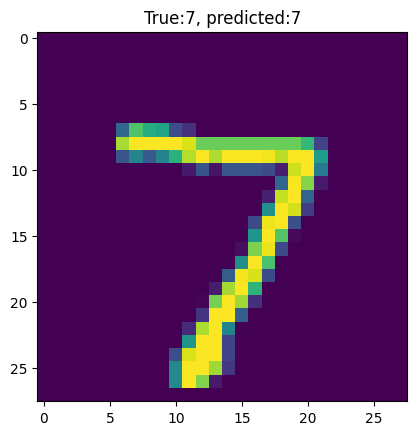

In [12]:
import matplotlib.pylab as plt

plt.imshow(test_images[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

### 모델 평가하기

In [13]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

In [14]:
print(evaluate_model(interpreter))

0.9642


다음을 얻기 위해 동적 범위 양자화 모델에 대한 평가를 반복합니다.


In [15]:
print(evaluate_model(interpreter_quant))

0.9638


이 예에서 압축된 모델은 정확성에 차이가 없습니다.

## 기존 모델 최적화하기

사전 활성화 레이어 (Resnet-v2)가 있는 Resnet은 비전 애플리케이션에 널리 사용됩니다. resnet-v2-101에 대해 사전 훈련된 고정 그래프는 [Tensorflow Hub](https://tfhub.dev/google/imagenet/resnet_v2_101/classification/4)에서 사용할 수 있습니다.

다음과 같이 양자화를 사용하여 고정된 그래프를 TensorFLow Lite flatbuffer로 변환할 수 있습니다.


In [16]:
import tensorflow_hub as hub

resnet_v2_101 = tf.keras.Sequential([
  keras.layers.InputLayer(input_shape=(224, 224, 3)),
  hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_101/classification/4")
])

converter = tf.lite.TFLiteConverter.from_keras_model(resnet_v2_101)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [17]:
# Convert to TF Lite without quantization
resnet_tflite_file = tflite_models_dir/"resnet_v2_101.tflite"
resnet_tflite_file.write_bytes(converter.convert())

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpsvt1tisp/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpsvt1tisp/assets


2022-12-15 01:03:49.703095: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-15 01:03:49.703150: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


178422328

In [18]:
# Convert to TF Lite with quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
resnet_quantized_tflite_file = tflite_models_dir/"resnet_v2_101_quantized.tflite"
resnet_quantized_tflite_file.write_bytes(converter.convert())

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpsfg1r109/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpsfg1r109/assets


2022-12-15 01:04:16.044587: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-15 01:04:16.044638: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


45733968

In [19]:
!ls -lh {tflite_models_dir}/*.tflite

-rw-rw-r-- 1 kbuilder kbuilder  83K Dec 15 01:03 /tmp/mnist_tflite_models/mnist_model.tflite
-rw-rw-r-- 1 kbuilder kbuilder  24K Dec 15 01:03 /tmp/mnist_tflite_models/mnist_model_quant.tflite
-rw-rw-r-- 1 kbuilder kbuilder  25K Dec 15 00:58 /tmp/mnist_tflite_models/mnist_model_quant_16x8.tflite
-rw-rw-r-- 1 kbuilder kbuilder  44K Dec 15 00:56 /tmp/mnist_tflite_models/mnist_model_quant_f16.tflite
-rw-rw-r-- 1 kbuilder kbuilder 171M Dec 15 01:03 /tmp/mnist_tflite_models/resnet_v2_101.tflite
-rw-rw-r-- 1 kbuilder kbuilder  44M Dec 15 01:04 /tmp/mnist_tflite_models/resnet_v2_101_quantized.tflite


모델 크기가 171MB에서 43MB로 줄어듭니다. imagenet에서 이 모델의 정확성은 [TFLite 정확성 측정](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/tools/evaluation/tasks/imagenet_image_classification)을 위해 제공된 스크립트를 사용하여 평가할 수 있습니다.

최적화된 모델 상위 1개 정확성은 부동 소수점 모델과 같은 76.8입니다.